In [1]:
import anndata
import copy
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import ot
import pandas as pd
import pickle
import scanpy as sc
import scipy.stats
import seaborn as sb
import warnings


import lineageot.inference
import lineageot.simulation
import lineageot.evaluation

In [2]:
data_path = "data/"
save_dir = "plots/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)  

In [3]:
with open(data_path + 'pickled_filtered_anndata.p', 'rb') as file:
    adata = pickle.load(file)

In [4]:
with open(data_path + "packer_pickle_lineage_tree.p", 'rb') as file:
    full_reference_tree = pickle.load(file)

### Normalization and preprocessing

In [5]:
# Removing partially lineage-labeled cells

adata = adata[adata.obs['lineage'] == adata.obs['random_precise_lineage']]

#### Filtering cells + genes

In [6]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

Trying to set attribute `.obs` of view, copying.


In [7]:
%%time
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
adata

CPU times: user 10.6 s, sys: 560 ms, total: 11.1 s
Wall time: 2.9 s


AnnData object with n_obs × n_vars = 5123 × 20222
    obs: 'Unnamed: 0', 'Unnamed: 0.1', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'n_counts', 'log_counts', 'n_genes'
    var: 'Unnamed: 0', 'id', 'gene_short_name'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [8]:

adata.obs.index = adata.obs['cell']

adata = adata[adata.obs.index.sort_values()].copy()
# for some reason on linux we need to redo this
# possibly due to version change of anndata (or dependencies)
# it seems that the previous indexing changed the index
adata.obs.index = adata.obs['cell']

In [9]:
print("AnnData", anndata.__version__)
# issue above observed for AnnData 0.7.4

AnnData 0.7.4


### Embryo time selection

In [10]:
def assign_time_to_bin(bin_string):
    if bin_string == '< 100':
        return 75
    elif bin_string == '> 650':
        # arbitrary choice here
        return 700
    else:
        # end of time range
        return (0*int(bin_string[0:3]) + 1*int(bin_string[-3:]))
    return

In [11]:
# If you would like to save time by only running the evaluation
# on a subset of the cells, change num_subbatches to an integer larger than 1.

# randomly splitting each batch into subbatches 
# so that there are fewer cells and the evaluation runs faster
num_subbatches = 1
adata.obs['assigned_batch_time'] = adata.obs['embryo.time.bin'].map(lambda x: assign_time_to_bin(x)
                                                                   + np.random.randint(num_subbatches))

In [12]:
batches = adata.obs['assigned_batch_time'].unique()
batches = np.sort(batches)
print(batches)

[ 75 130 170 210 270 330 390 450 510 580 650 700]


In [13]:
def create_lineage_tree(adata, batch_time, reference_tree = full_reference_tree, obsm_key = 'X_pca'):
    selected_cells = adata[adata.obs['assigned_batch_time'] == batch_time]
    
    # no need to remove any nodes from the reference
    # (unobserved subtrees have no effect on the inference)
    new_tree = copy.deepcopy(full_reference_tree)
    
    bad_cell_list = []
    good_cell_list = []
    for cell in selected_cells.obs.index:
        cell_label = selected_cells.obs['random_precise_lineage'][cell]
        cell_index = adata.obs.index.get_loc(cell)
        
        parent = next(reference_tree.predecessors(cell_label))
        
        if batch_time <= new_tree.nodes[parent]['time']:
            warnings.warn('Nonpositive time to parent ('
                          + str(batch_time - new_tree.nodes[parent]['time'])
                          + ') encountered in batch '
                          + str(batch_time) 
                          + ' for cell ' + cell)
            bad_cell_list.append(cell)
            # filter this cell out
            continue
        else:
            good_cell_list.append(cell)
        
        new_tree.add_node(cell)
        new_tree.add_edge(parent, cell)
        
        new_tree.nodes[cell]['name'] = cell_label
        new_tree.nodes[cell]['time'] = batch_time
        new_tree.nodes[cell]['time_to_parent'] = batch_time - new_tree.nodes[parent]['time']
        new_tree.nodes[cell]['cell'] = lineageot.simulation.Cell(adata.obsm[obsm_key][cell_index, :], cell_label)
        
        assert(new_tree.nodes[cell]['time_to_parent'] >= 0)
        
        
    return new_tree, good_cell_list, bad_cell_list

In [14]:
%%time
trees_by_batch = [create_lineage_tree(adata, batch_time) for batch_time in batches]

/home/aden/anaconda3/envs/lineageOT/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Nonpositive time to parent (-147.0) encountered in batch 75 for cell GTGCGGTGTATGGTTC-b01
/home/aden/anaconda3/envs/lineageOT/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Nonpositive time to parent (-52.0) encountered in batch 130 for cell TACGGATGTACCCAAT-b01
/home/aden/anaconda3/envs/lineageOT/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Nonpositive time to parent (-2.0) encountered in batch 170 for cell ACATCAGCAATCCAAC-r17
/home/aden/anaconda3/envs/lineageOT/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Nonpositive time to parent (-12.0) encountered in batch 170 for cell ATCTGCCAGGCATTGG-r17
/home/aden/anaconda3/envs/lineageOT/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Nonpositive time to parent (-20.0) encountered in batch 170 for cell CACTCCAAGCTGCCCA-r17
/home/aden/anaconda3/envs/lineageOT/

/home/aden/anaconda3/envs/lineageOT/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Nonpositive time to parent (-10.0) encountered in batch 270 for cell CACACAAAGGGAACGG-300.1.2
/home/aden/anaconda3/envs/lineageOT/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Nonpositive time to parent (-20.0) encountered in batch 270 for cell CCTAAAGAGGGCTCTC-400.2.1


CPU times: user 2.11 s, sys: 16 ms, total: 2.13 s
Wall time: 2.12 s


In [15]:
# Counting the number of cells kept vs. filtered out
# for having a measurement time at or before their
# reference birth time
{batch_time : (len(t[1]), len(t[2])) for t,batch_time in zip(trees_by_batch, batches)}

{75: (0, 1),
 130: (14, 1),
 170: (151, 14),
 210: (755, 79),
 270: (1215, 2),
 330: (1534, 0),
 390: (678, 0),
 450: (463, 0),
 510: (206, 0),
 580: (2, 0),
 650: (5, 0),
 700: (3, 0)}

#### Making a ground truth coupling

In [16]:
def is_ancestor(late_cell, early_cell):
    if not late_cell[-1] in 'aplrdvx':
        warnings.warn('Ancestor checking not implemented for cell ' + late_cell + ' yet.')
        return
    else:
        return early_cell in late_cell

In [17]:
def ground_truth_coupling(early_tree, late_tree, early_cells, late_cells):
    n_early = len(early_cells)
    n_late = len(late_cells)
    coupling = np.zeros([n_early, n_late])
    for c_early, i in zip(early_cells, range(n_early)):
        for c_late, j in zip(late_cells, range(n_late)):
            if is_ancestor(late_tree.nodes[c_late]['name'],
                           early_tree.nodes[c_early]['name']):
                coupling[i, j] = 1
    
    # filter out zero rows and columns
    kept_early_cells = np.where(np.sum(coupling, 1) > 0)[0]
    kept_late_cells = np.where(np.sum(coupling, 0) > 0)[0]
    coupling = coupling[np.ix_(kept_early_cells, kept_late_cells)]
    
    
    # normalize to uniform marginal on late cells
    coupling = np.dot(coupling, np.diag(np.sum(coupling, 0)**(-1)))/len(kept_late_cells)
    
    return coupling, kept_early_cells, kept_late_cells
    

In [18]:
couplings = {}

In [19]:
# Available base times: 170, 210, 270, 330, 390, 450

# The rest of the script only works with the coupling between
# early_batch_time and late_batch time
early_batch_time = 210 
late_batch_time = 270 
early_batch_index = np.where(batches == early_batch_time)[0][0]
late_batch_index = np.where(batches == late_batch_time)[0][0]
early_cells = trees_by_batch[early_batch_index][1]
late_cells = trees_by_batch[late_batch_index][1]

In [20]:
%%time
print((batches[early_batch_index], batches[late_batch_index]))
couplings['true'], kept_early_cells_index, kept_late_cells_index = ground_truth_coupling(trees_by_batch[early_batch_index][0],
                                                                             trees_by_batch[late_batch_index][0],
                                                                             trees_by_batch[early_batch_index][1],
                                                                             trees_by_batch[late_batch_index][1])

(210, 270)
CPU times: user 1.19 s, sys: 4 ms, total: 1.2 s
Wall time: 1.15 s


In [21]:
early_marginal = np.sum(couplings['true'], 1)
late_marginal = np.sum(couplings['true'], 0)

In [22]:
def remove_unlisted_leaves(tree, kept_leaves, max_depth = 10):
    """
    Removes all leaves not listed in kept_leaves from the tree
    """
    
    for i in range(max_depth):
        all_leaves = lineageot.inference.get_leaves(tree, include_root = False)
        for leaf in all_leaves:
            if not leaf in kept_leaves:
                tree.remove_node(leaf)
                
                
    return 

#### LineageOT coupling

In [23]:
lineageOT_tree = copy.deepcopy(trees_by_batch[late_batch_index][0])




In [24]:
remove_unlisted_leaves(lineageOT_tree,
                       np.array(trees_by_batch[late_batch_index][1])[kept_late_cells_index], max_depth = 15)


In [25]:
lineageot.inference.add_nodes_at_time(lineageOT_tree, early_batch_time)
lineageot.inference.add_times_to_edges(lineageOT_tree)

In [26]:
observed_nodes = trees_by_batch[late_batch_index][1]
lineageot.inference.add_conditional_means_and_variances(lineageOT_tree, observed_nodes)

In [27]:
ancestor_info = lineageot.inference.get_ancestor_data(lineageOT_tree, early_batch_time)


In [28]:
# Optimal transport coupling

In [29]:
lineage_rna_cost = ot.utils.dist(adata[early_cells].obsm['X_pca'],
                                 ancestor_info[0])@np.diag(ancestor_info[1]**(-1))
rna_cost = ot.utils.dist(adata[early_cells].obsm['X_pca'],
                         adata[late_cells].obsm['X_pca'])

late_time_rna_cost = ot.utils.dist(adata[late_cells].obsm['X_pca'],
                                   adata[late_cells].obsm['X_pca'])
# note early_time_rna_cost here is different from in the simulation evaluation because we don't have
# a single true ancestor for each late cell
early_time_rna_cost = ot.utils.dist(adata[early_cells].obsm['X_pca'],
                                    adata[early_cells].obsm['X_pca'])



lineage_rna_cost = lineage_rna_cost[kept_early_cells_index, :]
rna_cost = rna_cost[np.ix_(kept_early_cells_index, kept_late_cells_index)]
early_time_rna_cost = early_time_rna_cost[np.ix_(kept_early_cells_index, kept_early_cells_index)]
late_time_rna_cost = late_time_rna_cost[np.ix_(kept_late_cells_index, kept_late_cells_index)]

In [30]:
# checking that shapes match where they should
[x.shape for x in [lineage_rna_cost, rna_cost, early_time_rna_cost, late_time_rna_cost]]

[(740, 1024), (740, 1024), (740, 740), (1024, 1024)]

In [31]:
epsilons = np.array([0.1, 0.5,
                     1,
                     2,
                     2.5,
                     3, 5, 10, 20, 50, 100, 200, 300
                    ])*1


couplings['OT'] = ot.emd([],[],rna_cost)
couplings['lineageOT'] = ot.emd([], [], lineage_rna_cost)
for e in epsilons:
    print("Working on couplings for epsilon = " + str(e))
    if e < 1:
        f = ot.bregman.sinkhorn_epsilon_scaling
    else:
        f = ot.sinkhorn
    couplings['entropic rna ' + str(e)] = f(early_marginal,late_marginal,rna_cost, e)
    couplings['lineage entropic rna ' + str(e)] = f(early_marginal, late_marginal, lineage_rna_cost, e*np.mean(ancestor_info[1]**(-1)))


Working on couplings for epsilon = 0.1
Working on couplings for epsilon = 0.5
Working on couplings for epsilon = 1.0
Working on couplings for epsilon = 2.0
Working on couplings for epsilon = 2.5
Working on couplings for epsilon = 3.0
Working on couplings for epsilon = 5.0
Working on couplings for epsilon = 10.0
Working on couplings for epsilon = 20.0
Working on couplings for epsilon = 50.0
Working on couplings for epsilon = 100.0
Working on couplings for epsilon = 200.0
Working on couplings for epsilon = 300.0


In [32]:
# Removing couplings computed incorrectly with numerical errors (likely from too small epsilon)
improper_couplings = [key for key in couplings if abs(np.sum(couplings[key])-1) > 0.01]

for key in improper_couplings:
    print(key)
    couplings[key] = np.nan*np.ones(couplings[key].shape)

### Evaluation of fitted couplings

In [33]:
def print_metrics(couplings, cost_func, cost_func_name, log = False):
    
    l = max([len(c) for c in couplings.keys()])
    print(cost_func_name)
    for c in couplings.keys():
        loss = cost_func(couplings[c])
        if log:
            loss = np.log(loss)
        print(c.ljust(l), ": ", "{:.3f}".format(loss))
    print("\n")
    return


def plot_metrics(couplings, cost_func, cost_func_name, epsilons, scale = 1, log = False):
    zero_offset = epsilons[0]/2
    all_ys = []
    if "lineageOT" in couplings.keys():
        ys = []
        for c, e in zip([couplings['lineage entropic rna ' + str(e)] for e in epsilons], epsilons):
            print("Working on cost function for LineageOT coupling with epsilon = " + str(e))
            ys.append(cost_func(c))
            print("Finished LineageOT coupling with epsilon = " + str(e))
            print("Cost: " + str(ys[-1]) + "\n")
        plt.plot(epsilons, ys/scale, label = "LineageOT, true tree")
        all_ys.append(ys)
        #plt.scatter([zero_offset], [cost_func(couplings["lineageOT"])])
    if "OT" in couplings.keys():
        ys = []
        for c, e in zip([couplings['entropic rna ' + str(e)] for e in epsilons], epsilons):
            print("Working on cost function for OT coupling with epsilon = " + str(e))
            ys.append(cost_func(c))
            print("Finished OT coupling with epsilon = " + str(e))
            print("Cost: " + str(ys[-1]) + "\n")
        plt.plot(epsilons, ys/scale, label = "Entropic OT")
        all_ys.append(ys)
        #plt.scatter([zero_offset], [cost_func(couplings["OT"])])

    
    plt.ylabel(cost_func_name)
    plt.xlabel("Entropy parameter")
    plt.xscale("log")
    plt.xlim([epsilons[0], epsilons[-1]])
    plt.ylim([0,None])
    plt.legend()
    return all_ys



In [34]:
couplings['independent'] = np.outer(early_marginal, late_marginal)

In [35]:
%%time
ind_early_cost = lineageot.inference.OT_cost(lineageot.evaluation.expand_coupling(couplings['independent'].T, couplings['true'].T, early_time_rna_cost ).T
                                                 , early_time_rna_cost)
print(ind_early_cost)

ind_late_cost = lineageot.inference.OT_cost(lineageot.evaluation.expand_coupling(couplings['independent'], couplings['true'], late_time_rna_cost ).T
                                                 , late_time_rna_cost)
print(ind_late_cost)

96.81872690439816
113.41155678814738
CPU times: user 18.3 s, sys: 20 ms, total: 18.3 s
Wall time: 17.7 s


In [36]:
%%time
ot_early_cost = lineageot.inference.OT_cost(lineageot.evaluation.expand_coupling(couplings['OT'].T, couplings['true'].T, early_time_rna_cost ).T
                                                 , early_time_rna_cost)
print(ot_early_cost)
ot_late_cost = lineageot.inference.OT_cost(lineageot.evaluation.expand_coupling(couplings['OT'], couplings['true'], late_time_rna_cost ).T
                                                 , late_time_rna_cost)
print(ot_late_cost)

105.1924296992997
120.00814626806672
CPU times: user 13 s, sys: 28 ms, total: 13.1 s
Wall time: 11.9 s


In [37]:
%%time
lineageOT_early_cost = lineageot.inference.OT_cost(lineageot.evaluation.expand_coupling(couplings['lineageOT'].T, couplings['true'].T, early_time_rna_cost ).T
                                                 , early_time_rna_cost)
print(lineageOT_early_cost)
lineageOT_late_cost = lineageot.inference.OT_cost(lineageot.evaluation.expand_coupling(couplings['lineageOT'], couplings['true'], late_time_rna_cost ).T
                                                 , late_time_rna_cost)
print(lineageOT_late_cost)

102.89165769088184
122.31720584976263
CPU times: user 13.2 s, sys: 28 ms, total: 13.2 s
Wall time: 12.1 s


Working on cost function for LineageOT coupling with epsilon = 0.1
Finished LineageOT coupling with epsilon = 0.1
Cost: 52.65557454346154

Working on cost function for LineageOT coupling with epsilon = 0.5
Finished LineageOT coupling with epsilon = 0.5
Cost: 50.40994069523075

Working on cost function for LineageOT coupling with epsilon = 1.0
Finished LineageOT coupling with epsilon = 1.0
Cost: 47.808325760289165

Working on cost function for LineageOT coupling with epsilon = 2.0
Finished LineageOT coupling with epsilon = 2.0
Cost: 44.13761475247741

Working on cost function for LineageOT coupling with epsilon = 2.5
Finished LineageOT coupling with epsilon = 2.5
Cost: 42.95188974371057

Working on cost function for LineageOT coupling with epsilon = 3.0
Finished LineageOT coupling with epsilon = 3.0
Cost: 42.100062828067166

Working on cost function for LineageOT coupling with epsilon = 5.0
Finished LineageOT coupling with epsilon = 5.0
Cost: 41.3189673049437

Working on cost function f

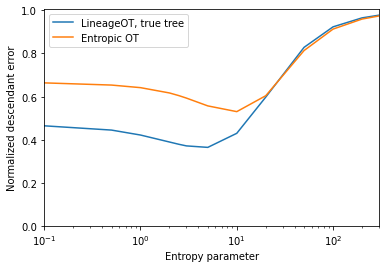

In [38]:
%%time
late_time_errors = plot_metrics(couplings, lambda x:lineageot.inference.OT_cost(lineageot.evaluation.expand_coupling(x,
                                                                                             couplings['true'], 
                                                                                             late_time_rna_cost)
                                                 , late_time_rna_cost),
                                'Normalized descendant error', 
                                epsilons,
                                scale = ind_late_cost
                               )

Working on cost function for LineageOT coupling with epsilon = 0.1
Finished LineageOT coupling with epsilon = 0.1
Cost: 52.26748559526623

Working on cost function for LineageOT coupling with epsilon = 0.5
Finished LineageOT coupling with epsilon = 0.5
Cost: 49.303868137332195

Working on cost function for LineageOT coupling with epsilon = 1.0
Finished LineageOT coupling with epsilon = 1.0
Cost: 46.0330453241342

Working on cost function for LineageOT coupling with epsilon = 2.0
Finished LineageOT coupling with epsilon = 2.0
Cost: 41.426640325979754

Working on cost function for LineageOT coupling with epsilon = 2.5
Finished LineageOT coupling with epsilon = 2.5
Cost: 39.94043990554958

Working on cost function for LineageOT coupling with epsilon = 3.0
Finished LineageOT coupling with epsilon = 3.0
Cost: 38.849555360914714

Working on cost function for LineageOT coupling with epsilon = 5.0
Finished LineageOT coupling with epsilon = 5.0
Cost: 37.19391319328563

Working on cost function 

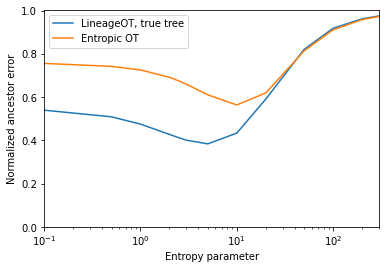

In [39]:
%%time
early_time_errors = plot_metrics(couplings, lambda x:lineageot.inference.OT_cost(lineageot.evaluation.expand_coupling(x.T,
                                                                                             couplings['true'].T, 
                                                                                             early_time_rna_cost ).T
                                                 , early_time_rna_cost),
                                'Normalized ancestor error', 
                                epsilons,
                                scale = ind_early_cost
                               )

In [40]:
def plot_precomputed_metrics(all_ys, cost_func_name, epsilons, scale = 1, log = False, label_font_size = 18, tick_font_size = 12):
        
    plt.plot(epsilons, all_ys[0]/scale, label = "LineageOT, true tree")

    plt.plot(epsilons, all_ys[1]/scale, label = "Entropic OT")
        
    
    plt.ylabel(cost_func_name, fontsize=label_font_size)
    plt.xlabel("Entropy parameter", fontsize=label_font_size)
    plt.xscale("log")
    plt.xlim([epsilons[0], epsilons[-1]])
    plt.ylim([0,None])
    plt.legend(fontsize=tick_font_size)                 
    plt.xticks(fontsize=tick_font_size)  
    plt.yticks(fontsize=tick_font_size)  
                                          
    return 


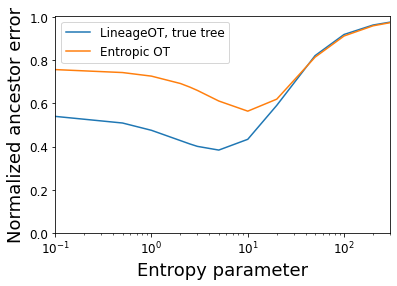

In [41]:
if (early_batch_time, late_batch_time) == (210,270):
    plot_precomputed_metrics(early_time_errors, "Normalized ancestor error", epsilons, scale = ind_early_cost)
    plt.savefig(save_dir + "figure_3c.pdf", bbox_inches = "tight")

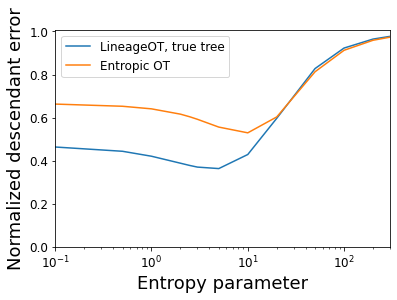

In [42]:
if (early_batch_time, late_batch_time) == (210,270):
    plot_precomputed_metrics(late_time_errors, "Normalized descendant error", epsilons, scale = ind_late_cost)
    plt.savefig(save_dir + "figure_3d.pdf", bbox_inches = "tight")

### Which cells does LineageOT predict better?

In [43]:
ancestor_errors = {}
descendant_errors = {}
label_font_size = 18
tick_font_size = 12

In [44]:
best_coupling_keys = ['lineage entropic rna 5.0', 'entropic rna 10.0']
for key in best_coupling_keys:
    ancestor_errors[key] = [ot.emd2(couplings[key][:, i]/np.sum(couplings[key][:, i]),
                                    couplings['true'][:, i]/np.sum(couplings['true'][:, i]),
                                    early_time_rna_cost)
                            for i in range(couplings['true'].shape[1])]
    descendant_errors[key] = [ot.emd2(couplings[key][i, :]/np.sum(couplings[key][i, :]),
                                      couplings['true'][i, :]/np.sum(couplings['true'][i, :]),
                                      late_time_rna_cost)
                            for i in range(couplings['true'].shape[0])]

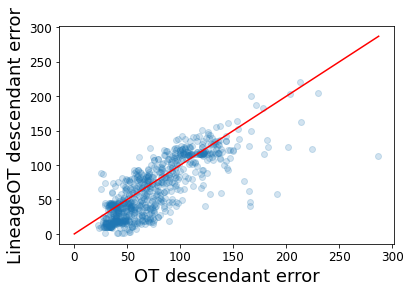

In [45]:
xmax = np.max(descendant_errors[best_coupling_keys[1]])
plt.scatter(descendant_errors[best_coupling_keys[1]],
            descendant_errors[best_coupling_keys[0]],
            alpha = 0.2
           )
plt.plot([0,1+xmax], [0, 1+xmax], color = 'r')
plt.ylabel('LineageOT descendant error', fontsize=label_font_size)
plt.xlabel('OT descendant error', fontsize=label_font_size)

plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

if (early_batch_time, late_batch_time) == (210,270):
    plt.savefig(save_dir + "figure_S5a.pdf", bbox_inches = "tight")

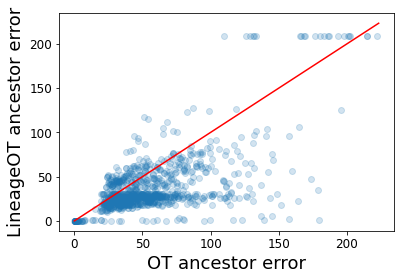

In [46]:
xmax = np.max(ancestor_errors[best_coupling_keys[1]])
plt.scatter(ancestor_errors[best_coupling_keys[1]],
            ancestor_errors[best_coupling_keys[0]],
            alpha = 0.2
           )
plt.plot([0,1+xmax], [0, 1+xmax], color = 'r')
plt.ylabel('LineageOT ancestor error', fontsize=label_font_size)
plt.xlabel('OT ancestor error', fontsize=label_font_size)

plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

if (early_batch_time, late_batch_time) == (210,270):
    plt.savefig(save_dir + "figure_3b.pdf", bbox_inches = "tight")